In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import hdbscan
import pprint
import re
import scipy.sparse
import sys
import time
import umap

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from helper_functions import *
from fbpca import pca
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from os import listdir
from os.path import isfile, join
from tqdm import tqdm

from helper_clustering import get_heuristics_kmeans, get_heuristics_spectral

# Helpers Functions

In [3]:
def load_data(standardized=True, td_idf=True, dim_red=50):
    """
    Load all the relevant data for perform user and artist based clustering.
    """

    if td_idf:
        filename = '../data/artist_embeddings/pca/artist_embedding_transformed_pca{}.pickle'.format(
            dim_red)
    else:
        filename = '../data/artist_embeddings/pca/artist_embedding_norm_transformed_pca{}.pickle'.format(
            dim_red)

    X = load_pickle(filename)

    # Standardize the reduced matrix
    if standardized:
        standard_scaler = StandardScaler()
        X = standard_scaler.fit_transform(X)

    artist2id = load_pickle('../data/artist2id.pickle')
    id2artist = load_pickle('../data/id2artist.pickle')

    user2id = load_pickle('../data/user2id.pickle')
    id2user = load_pickle('../data/id2user.pickle')

    return X, artist2id, id2artist, user2id, id2user

In [4]:
def cluster_hdbscan(matrix, min_cluster_size=300, min_samples=30):
    """
    Perform a clustering model with HDBSCAN algorithm.
    """

    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                    min_samples=min_samples)
    hdbscan_model.fit(matrix)

    labels = hdbscan_model.labels_
    centers = hdbscan_model.exemplars_

    return hdbscan_model, labels, centers

In [5]:
def cluster_gmm(matrix, k=8):
    """
    Perform a clustering model with Gaussian Mixture Model algorithm.
    """

    gmm_model = GMM(k, covariance_type='full', random_state=0, n_init=10)
    gmm_model.fit(matrix)

    labels = gmm_model.predict(matrix)
    centers = gmm_model.means_

    return gmm_model, labels, centers

In [6]:
def plot_tune_gmm(ks, scores, standardized=True, td_idf=True, dim_red=50):
    """
    From the Davies Bouldin score on the GMM models, visualize it.
    """

    f = plt.figure(figsize=(12, 8))

    plt.plot(ks, scores, label='davies_bouldin_score')
    plt.xticks(ks)

    plt.title('Davies Bouldin score for tuning GMM model', fontsize=24)
    plt.grid()
    plt.legend()

    figname = 'gmm_scores_tdidf{}_dim{}_standardized.pdf'.format(
        td_idf, dim_red, standardized)
    plt.savefig('../data/plots/{}'.format(figname))

    plt.show()

In [7]:
def tune_gmm(X, k_min, k_max, standardized=True, td_idf=True, dim_red=50):
    """
    Get the optimal K number of cluster on the GMM model.
    """

    ks = []
    scores = []

    for k in tqdm(range(k_min, k_max + 1)):
        model, labels, cluster_centers = cluster_gmm(X, k=k)

        score = davies_bouldin_score(X, labels)

        ks.append(k)
        scores.append(score)

    opt_k = ks[np.argmin(scores)]
    print('K that minimizes Davies Bouldin score: {}'.format(opt_k))

    plot_tune_gmm(ks, scores, standardized, td_idf, dim_red)

    return opt_k, scores

In [8]:
def compute_user_means(X, matrix_plays, id2user):
    """
    Compute the artist vector for each user. 
    """

    # Get weight per artist for each user with the normalized number of plays
    matrix_plays_normed = normalize(matrix_plays, norm='l1', axis=1)

    user_means = {}

    for i in tqdm(range(matrix_plays.shape[0])):

        user_row = matrix_plays_normed[i]
        _, artists_idx = user_row.nonzero()

        weights = matrix_plays_normed[i, artists_idx]
        artists_vect = X[artists_idx]

        user_means[id2user[i]] = weights @ artists_vect

    return user_means

In [9]:
def build_matrix_clustering(user_means, artist_model, artist_centers):
    """
    Get the probabilities that each user like the clusters of artists.
    """

    ar_users_clusters = np.zeros((len(user_means), artist_centers.shape[0]))

    for i, user in tqdm(enumerate(user_means)):

        user_mean = user_means[user].flatten()

        ar_users_clusters[i] = artist_model.predict_proba([user_mean])

    return ar_users_clusters

In [10]:
def get_2d_projection(ar_users_clusters):
    """
    Get the 2D projection of the new user embedding
    """

    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=0)
    tsne_results = tsne.fit_transform(ar_users_clusters)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time() -
                                                        time_start))

    return tsne_results

In [11]:
def hdbscan_visualize(ar_users_clusters_scaled,
                      tsne_results,
                      min_cluster_size=50,
                      min_samples=15,
                      standardized=True,
                      td_idf=True,
                      dim_red=50):
    """
    Plot the 2D projection of the users with the corresponding label class given by the HDBSCAN model.
    """

    user_model, user_labels, user_cluster_centers = cluster_hdbscan(
        ar_users_clusters_scaled, min_cluster_size, min_samples)

    df_visualization = pd.DataFrame()

    df_visualization["First_dimension"] = tsne_results[:, 0]
    df_visualization["Second_dimension"] = tsne_results[:, 1]
    df_visualization["cluster_labels"] = user_labels

    nb_clusters = len(set(user_labels))

    plt.figure(figsize=(16, 10))
    ax = sns.scatterplot(x="First_dimension",
                         y="Second_dimension",
                         hue="cluster_labels",
                         palette=sns.color_palette("hls", nb_clusters),
                         data=df_visualization,
                         legend="full",
                         alpha=0.3)

    plt.suptitle('HDBSCAN on the users', fontsize=24)
    plt.title(
        'Standardized: {}, TD-IDF: {}, Dim. Red.: {}, Min cluster size: {}, Min sample: {}'
        .format(standardized, td_idf, dim_red, min_cluster_size, min_samples),
        fontsize=20)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('First_dimension', fontsize=20)
    plt.ylabel('Second_dimension', fontsize=20)
    plt.setp(ax.get_legend().get_texts(), fontsize='12')
    plt.setp(ax.get_legend().get_title(), fontsize='18')

    plt.tight_layout()
    plt.show()

    figname = 'hdbscan_user_standardize{}_tdifd{}_dim{}_minClusterSize{}_minSample{}.pfd'.format(
        standardized, td_idf, dim_red, min_cluster_size, min_samples)

    return user_model, user_labels, user_cluster_centers

In [49]:
def user_level_clustering(standardized=True, td_idf=True, dim_red=50):
    """
    Pipeline for the user clustering.
    """

    # Load data
    print('###Loading data...\n')
    X, artist2id, id2artist, user2id, id2user = load_data(
        standardized, td_idf, dim_red)

    # Compute user vector
    print('###Computing user means vector...\n')
    matrix_plays = scipy.sparse.load_npz('../data/matrix_plays.npz').T
    user_means = compute_user_means(X, matrix_plays, id2user)

    # Get optimal K for artist GMM model
    print('###Tuning artist GMM model...\n')
    opt_k, gmm_scores = tune_gmm(X, 10, 25, standardized, td_idf, dim_red)

    # Get artist GMM model
    print('###Computing artist GMM model...\n')
    artist_model, artist_labels, artist_centers = cluster_gmm(X, opt_k)

    # Compute matrix for user clustering
    print('###Computing matrix for clustering...\n')
    ar_users_clusters = build_matrix_clustering(user_means, artist_model,
                                                artist_centers)

    # Get 2D-projection
    print('###Computing 2D-projection...\n')
    tsne_results = get_2d_projection(ar_users_clusters)

    return ar_users_clusters, tsne_results, id2user, artist_model, artist_labels, artist_centers, gmm_scores

# Get User-level clustering

## dim = 25, td_idf = true

In [51]:
standardized = True
td_idf = True
dim_red = 25

### K-Means

In [14]:
# Optimal Parameter
k = 26

In [15]:
# Load the user embedding
X_users = load_pickle(
    '../data/user_embeddings/pca/user_embedding_transformed_pca25.pickle')

# Standardize the embedding matrix
standard_scaler = StandardScaler()
X_users = standard_scaler.fit_transform(X_users)

# Apply K-Means model
kmeans_model = KMeans(n_clusters=k, random_state=0).fit(X_users)

# Get User Label
user_labels_kmeans = kmeans_model.labels_

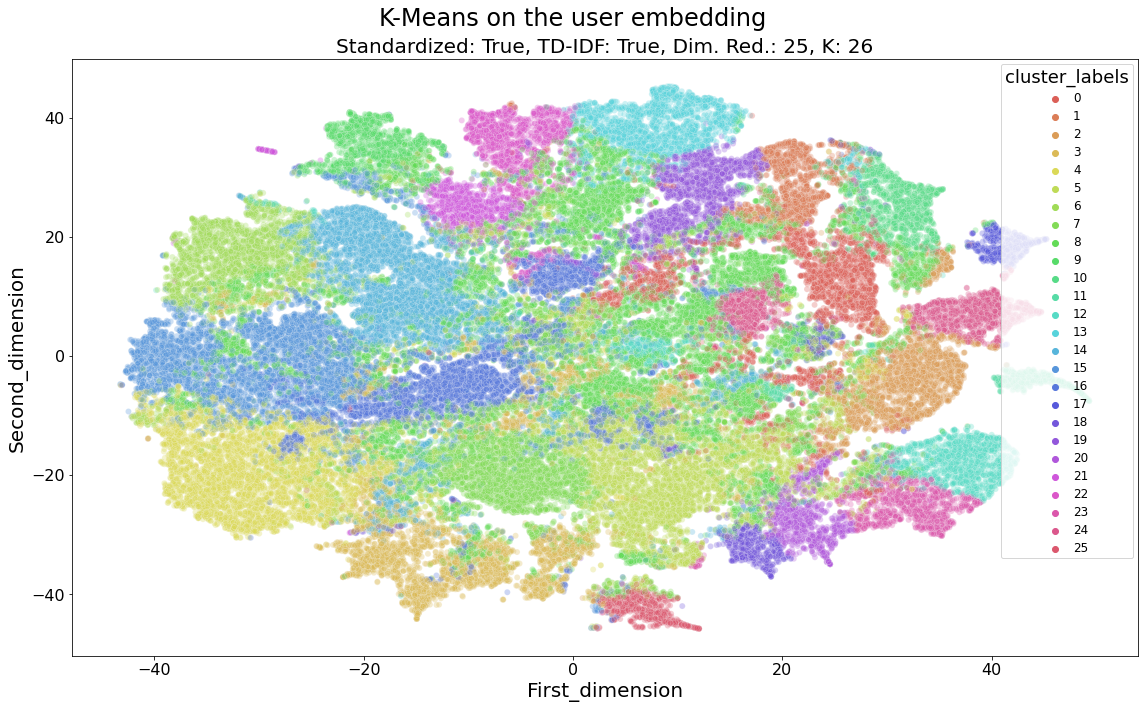

In [16]:
# Visualize 2D projection of the user embedding with K-Means
tsne = TSNE(n_components=2, verbose=0)
tsne_results_kmeans = tsne.fit_transform(X_users)

# Store results
df_visualization = pd.DataFrame()
df_visualization["First_dimension"] = tsne_results_kmeans[:, 0]
df_visualization["Second_dimension"] = tsne_results_kmeans[:, 1]
df_visualization["cluster_labels"] = user_labels_kmeans

# Plot
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="First_dimension",
                     y="Second_dimension",
                     hue="cluster_labels",
                     palette=sns.color_palette("hls", k),
                     data=df_visualization,
                     legend="full",
                     alpha=0.3)

plt.suptitle('K-Means on the user embedding', fontsize=24)
plt.title('Standardized: {}, TD-IDF: {}, Dim. Red.: {}, K: {}'.format(
    standardized, td_idf, dim_red, k),
          fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('First_dimension', fontsize=20)
plt.ylabel('Second_dimension', fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='18')

plt.tight_layout()
plt.show()

### GMM with HDBSCAN

###Loading data...

###Computing user means vector...



  0%|          | 0/16 [00:00<?, ?it/s]

###Tuning artist GMM model...



100%|██████████| 16/16 [1:03:13<00:00, 237.12s/it]


K that minimizes Davies Bouldin score: 24


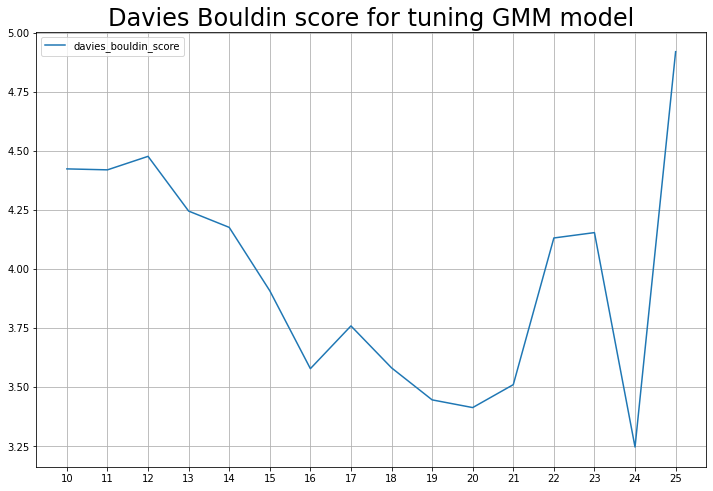

###Computing artist GMM model...



229it [00:00, 1057.02it/s]

###Computing matrix for clustering...



94407it [01:02, 1511.80it/s]


###Computing 2D-projection...

t-SNE done! Time elapsed: 1052.389689207077 seconds


In [52]:
ar_users_clusters, tsne_results, id2user, artist_model, artist_labels, artist_centers, gmm_scores = user_level_clustering(
    standardized, td_idf, dim_red)

In [53]:
save_to_pickle(artist_labels, 'gmm_artist_labels', '../data/clustering/')

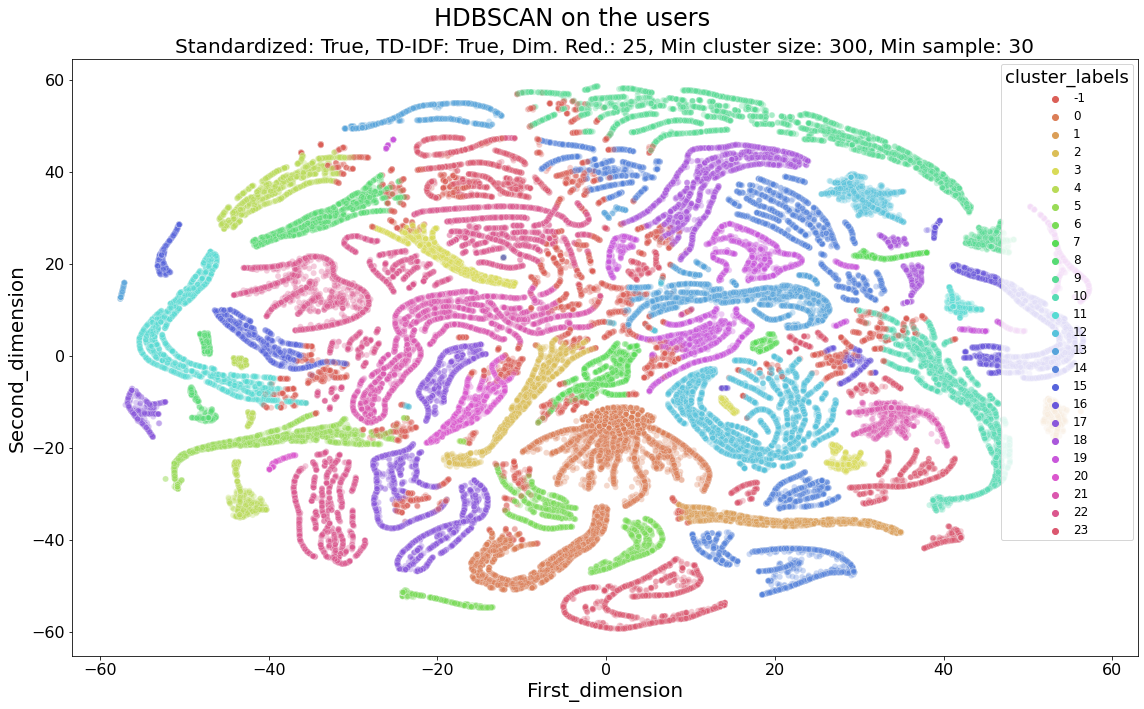

In [18]:
user_model, user_labels, user_centers = hdbscan_visualize(ar_users_clusters,
                                                          tsne_results,
                                                          min_cluster_size=300,
                                                          min_samples=30,
                                                          dim_red=dim_red)

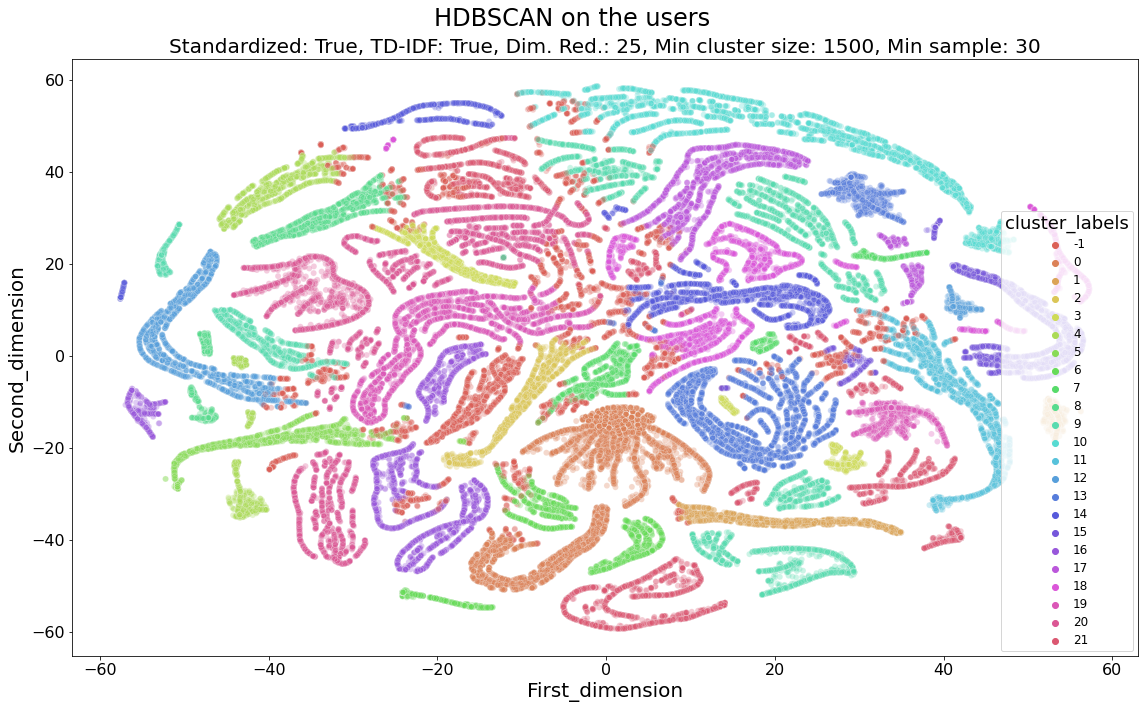

In [19]:
user_model, user_labels, user_centers = hdbscan_visualize(ar_users_clusters,
                                                          tsne_results,
                                                          min_cluster_size=1500,
                                                          min_samples=30,
                                                          dim_red=dim_red)

## dim = 50, td_idf = true

In [20]:
standardized = True
td_idf = True
dim_red = 50

###Loading data...

###Computing user means vector...



  0%|          | 0/16 [00:00<?, ?it/s]

###Tuning artist GMM model...



100%|██████████| 16/16 [3:12:33<00:00, 722.10s/it]  


K that minimizes Davies Bouldin score: 25


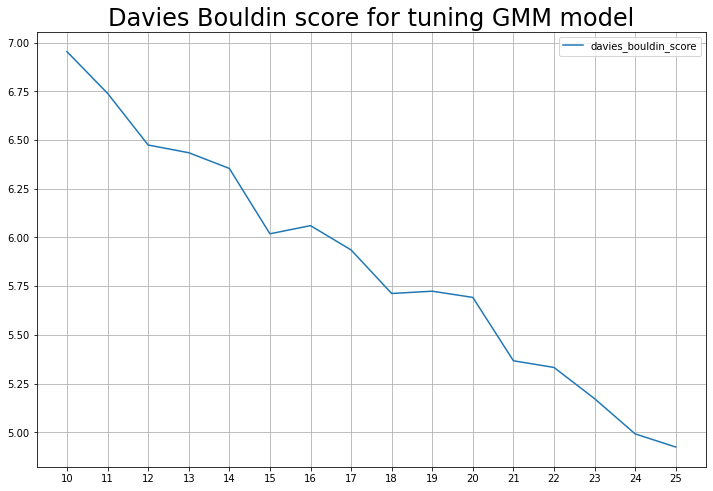

###Computing artist GMM model...



205it [00:00, 907.58it/s]

###Computing matrix for clustering...



94407it [01:08, 1380.95it/s]


###Computing 2D-projection...

t-SNE done! Time elapsed: 1197.6775090694427 seconds


In [21]:
ar_users_clusters_50, tsne_results_50, id2user_50, artist_model_50, artist_labels_50, artist_centers_50, gmm_scores_50 = user_level_clustering(
    standardized, td_idf, dim_red)

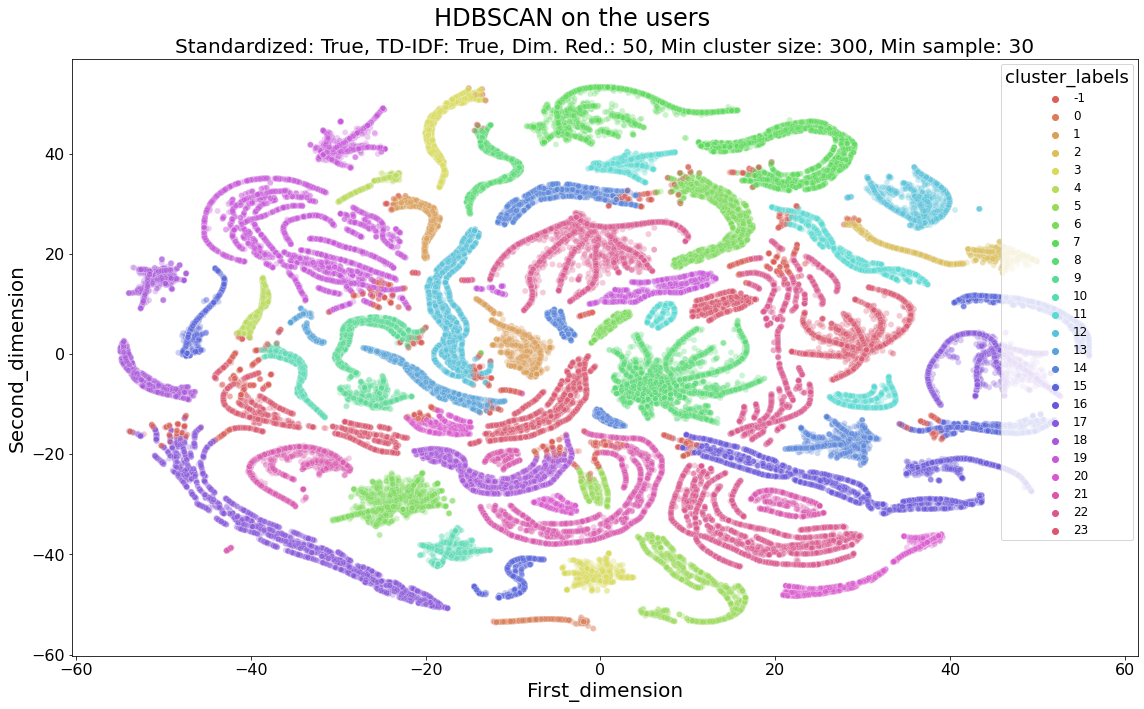

In [22]:
user_model_50, user_labels_50, user_centers_50 = hdbscan_visualize(
    ar_users_clusters_50, tsne_results_50, min_cluster_size=300, min_samples=30)

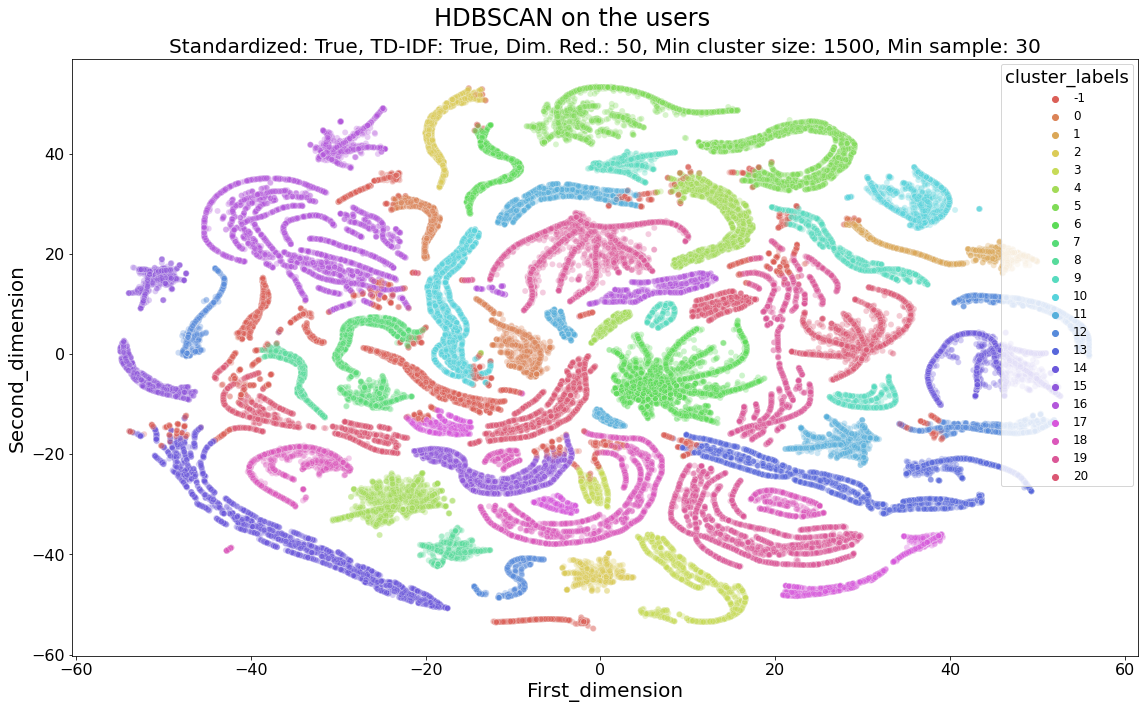

In [23]:
user_model_50, user_labels_50, user_centers_50 = hdbscan_visualize(
    ar_users_clusters_50,
    tsne_results_50,
    min_cluster_size=1500,
    min_samples=30)

# Get Group of artist for each user cluster

In [33]:
matrix_plays = scipy.sparse.load_npz('../data/matrix_plays.npz').T

user2id = load_pickle('../data/user2id.pickle')
id2user = load_pickle('../data/id2user.pickle')

artist2id = load_pickle('../data/artist2id.pickle')
id2artist = load_pickle('../data/id2artist.pickle')

In [24]:
col_names_consumption = [
    'user-mboxsha1', 'musicbrainz-artist-id', 'artist-name', 'plays'
]

df = pd.read_csv('../data/usersha1-artmbid-artname-plays.tsv',
                 sep='\t',
                 names=col_names_consumption)

In [25]:
df_artist = df[['musicbrainz-artist-id',
                'artist-name']].groupby('musicbrainz-artist-id',
                                        as_index=False).first()

In [26]:
artist_id2artist_name = dict(
    zip(df_artist['musicbrainz-artist-id'], df_artist['artist-name']))

In [27]:
def get_user2label(user_labels, id2user):

    label2user = {}

    for idx, user in tqdm(id2user.items()):

        user_label = user_labels[idx]

        if user_label in label2user.keys():
            label2user[user_label].append(user)
        else:
            label2user[user_label] = [user]

    return label2user

In [28]:
def get_top_artists_per_cluster(user_labels,
                                label2user,
                                matrix_plays,
                                user2id,
                                id2artist,
                                artist_id2artist_name,
                                n_top=10):

    for label in set(user_labels):

        # Get the user within the cluster
        user_cluster = label2user[label]
        user_cluster_id = [user2id[user] for user in user_cluster]

        # Get the average number of plays per artist per user within a cluster
        avg_plays = np.squeeze(
            np.asarray(matrix_plays[user_cluster_id].sum(axis=0) /
                       len(user_cluster)))

        # Get the top 10 artists in the cluster
        top_artist_idx = np.argsort(avg_plays)[::-1][:n_top]

        # Get the ID of the cluster
        top_artist = [id2artist[idx] for idx in top_artist_idx]
        avg_plays_top_artist = avg_plays[top_artist_idx]

        top_artist_name = [
            artist_id2artist_name[artist] for artist in top_artist
        ]

        print('\n### Top artist for cluster {}'.format(label))
        pprint.pprint(dict(zip(top_artist_name, avg_plays_top_artist)))

## dim = 25, td_idf = true

In [29]:
# Mapping user2label

label2user = get_user2label(user_labels, id2user)

100%|██████████| 94407/94407 [00:00<00:00, 745745.85it/s]


In [45]:
save_to_pickle(user_labels, 'hdbscan_user_labels', '../data/clustering/')

In [34]:
get_top_artists_per_cluster(user_labels,
                            label2user,
                            matrix_plays,
                            user2id,
                            id2artist,
                            artist_id2artist_name,
                            n_top=10)


### Top artist for cluster 0
{'belle and sebastian': 67.90583850931677,
 'bob dylan': 132.3992546583851,
 'cat power': 63.03900621118012,
 'coldplay': 50.48360248447205,
 'elliott smith': 65.48434782608696,
 'radiohead': 107.29229813664597,
 'sufjan stevens': 59.67229813664596,
 'the beatles': 163.8031055900621,
 'tom waits': 66.28608695652174,
 'wilco': 60.118136645962736}

### Top artist for cluster 1
{'against me!': 41.08270676691729,
 'alkaline trio': 41.99147869674186,
 'bad religion': 58.14335839598998,
 'coldplay': 46.391478696741856,
 'nofx': 51.371428571428574,
 'pink floyd': 53.13233082706767,
 'radiohead': 47.037092731829574,
 'the beatles': 104.0235588972431,
 'the lawrence arms': 47.3453634085213,
 'u2': 53.06917293233083}

### Top artist for cluster 2
{'bill evans': 40.825372367745246,
 'bob dylan': 83.79917822290703,
 'frank zappa': 69.2105803800719,
 'john coltrane': 69.14689265536722,
 'led zeppelin': 39.45916795069338,
 'miles davis': 121.54904982023626,
 'pink floyd

## dim = 50, td_idf = true

In [37]:
# Mapping user2label

label2user_50 = get_user2label(user_labels_50, id2user)

100%|██████████| 94407/94407 [00:00<00:00, 697091.47it/s]


In [38]:
get_top_artists_per_cluster(user_labels_50,
                            label2user_50,
                            matrix_plays,
                            user2id,
                            id2artist,
                            artist_id2artist_name,
                            n_top=10)


### Top artist for cluster 0
{'50 cent': 69.591727307545,
 'britney spears': 137.53542703944848,
 'eminem': 86.2834163155879,
 'kylie minogue': 173.31328992723095,
 'lady gaga': 79.96170049789353,
 'linkin park': 143.51168134814247,
 'madonna': 208.958636537725,
 'nelly furtado': 59.09498276522405,
 'rammstein': 78.85714285714286,
 'rihanna': 82.21447721179625}

### Top artist for cluster 1
{'boards of canada': 38.981427742309926,
 'bonobo': 45.36680208937899,
 'brandy': 62.48868253047011,
 'erykah badu': 48.35693557748114,
 'jamiroquai': 41.94428322692978,
 'janet jackson': 50.99477655252467,
 'larc~en~ciel': 42.19791062100987,
 'pink floyd': 40.338363319791064,
 'stevie wonder': 43.46256529309344,
 'thievery corporation': 50.84155542658154}

### Top artist for cluster 2
{'aphex twin': 49.627571115973744,
 'armin van buuren': 69.6183807439825,
 'atb': 58.34048140043764,
 'boards of canada': 70.49234135667396,
 'daft punk': 54.98336980306346,
 'infected mushroom': 63.29015317286652,
 

 # Get user demographic information within a same cluster

In [39]:
col_names_user = ['user-mboxsha1', 'gender', 'age', 'country', 'signup']
df_user = pd.read_csv('../data/usersha1-profile.tsv',
                      sep='\t',
                      names=col_names_user)
df_user.head()

user-mboxsha1 gender   age        country  \
0  00000c289a1829a808ac09c00daf10bc3c4e223b      f  22.0        Germany   
1  00001411dc427966b17297bf4d69e7e193135d89      f   NaN         Canada   
2  00004d2ac9316e22dc007ab2243d6fcb239e707d    NaN   NaN        Germany   
3  000063d3fe1cf2ba248b9e3c3f0334845a27a6bf      m  19.0         Mexico   
4  00007a47085b9aab8af55f52ec8846ac479ac4fe      m  28.0  United States   

         signup  
0   Feb 1, 2007  
1   Dec 4, 2007  
2   Sep 1, 2006  
3  Apr 28, 2008  
4  Jan 27, 2006

In [40]:
def get_demographic_data(user_labels):

    for label in set(user_labels):

        # Get the user within the cluster
        user_cluster = label2user[label]

        # Get demographic informations about user within a same cluster
        df_user_cluster = df_user[df_user['user-mboxsha1'].isin(
            set(user_cluster))]

        # Gender
        nb_male = df_user_cluster['gender'].value_counts().loc['m']
        nb_female = df_user_cluster['gender'].value_counts().loc['f']

        # Age
        mean_age = np.mean(df_user_cluster['age'])
        std_age = np.std(df_user_cluster['age'])

        # Country
        top_5_country = df_user_cluster['country'].value_counts()[:5].to_dict()

        print('\n### Demographic informations on cluster {}'.format(label))

        print('Mean age: {}'.format(mean_age))
        print('Std age: {}'.format(std_age))
        print('Proportion of Mens: {:.2f}%'.format(nb_male * 100 /
                                                   (nb_male + nb_female)))
        print('Proportion of Womens: {:.2f}%'.format(nb_female * 100 /
                                                     (nb_male + nb_female)))

        print('Top 5 countries: '.format(label))
        pprint.pprint(top_5_country)

## dim = 25, td_idf = true

In [41]:
get_demographic_data(user_labels)


### Demographic informations on cluster 0
Mean age: 27.687612502045493
Std age: 32.28533362863227
Proportion of Mens: 73.02%
Proportion of Womens: 26.98%
Top 5 countries: 
{'Brazil': 866,
 'Germany': 452,
 'Spain': 396,
 'United Kingdom': 777,
 'United States': 2095}

### Demographic informations on cluster 1
Mean age: 27.812215724496426
Std age: 10.714401303175867
Proportion of Mens: 84.64%
Proportion of Womens: 15.36%
Top 5 countries: 
{'Germany': 257,
 'Italy': 78,
 'Sweden': 121,
 'United Kingdom': 160,
 'United States': 499}

### Demographic informations on cluster 2
Mean age: 28.62249283667622
Std age: 53.3541182065863
Proportion of Mens: 84.87%
Proportion of Womens: 15.13%
Top 5 countries: 
{'Germany': 129,
 'Poland': 104,
 'Spain': 90,
 'United Kingdom': 194,
 'United States': 348}

### Demographic informations on cluster 3
Mean age: 25.040856031128406
Std age: 8.331040906607882
Proportion of Mens: 76.19%
Proportion of Womens: 23.81%
Top 5 countries: 
{'Germany': 178,
 'Russia

## dim = 50, td_idf = true

In [42]:
get_demographic_data(user_labels_50)


### Demographic informations on cluster 0
Mean age: 27.687612502045493
Std age: 32.28533362863227
Proportion of Mens: 73.02%
Proportion of Womens: 26.98%
Top 5 countries: 
{'Brazil': 866,
 'Germany': 452,
 'Spain': 396,
 'United Kingdom': 777,
 'United States': 2095}

### Demographic informations on cluster 1
Mean age: 27.812215724496426
Std age: 10.714401303175867
Proportion of Mens: 84.64%
Proportion of Womens: 15.36%
Top 5 countries: 
{'Germany': 257,
 'Italy': 78,
 'Sweden': 121,
 'United Kingdom': 160,
 'United States': 499}

### Demographic informations on cluster 2
Mean age: 28.62249283667622
Std age: 53.3541182065863
Proportion of Mens: 84.87%
Proportion of Womens: 15.13%
Top 5 countries: 
{'Germany': 129,
 'Poland': 104,
 'Spain': 90,
 'United Kingdom': 194,
 'United States': 348}

### Demographic informations on cluster 3
Mean age: 25.040856031128406
Std age: 8.331040906607882
Proportion of Mens: 76.19%
Proportion of Womens: 23.81%
Top 5 countries: 
{'Germany': 178,
 'Russia

# Validation

In [65]:
# Load testing data
matrix_plays_test = scipy.sparse.load_npz('../data/matrix_plays_test.npz').T
id2user_test = load_pickle('../data/id2user_test.pickle')
user2id_test = load_pickle('../data/user2id_test.pickle')

# Load artist embedding matrix
X = load_pickle(
    '../data/artist_embeddings/pca/artist_embedding_transformed_pca25.pickle')

# Standardize the embedding matrix
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(X)

# Compute user mean for test set
user_means_test = compute_user_means(X, matrix_plays_test, id2user_test)
ar_users_clusters_test = build_matrix_clustering(user_means_test, artist_model,
                                                 artist_centers)

user_test_labels, strengths = hdbscan.approximate_predict(
    user_model, ar_users_clusters_test)

100%|██████████| 10490/10490 [00:05<00:00, 2025.55it/s]
10490it [00:10, 994.36it/s] 


In [66]:
# Mapping label2user_test
label2user_test = get_user2label(user_test_labels, id2user_test)

100%|██████████| 10490/10490 [00:00<00:00, 804017.49it/s]


In [67]:
get_top_artists_per_cluster(user_test_labels, label2user_test,
                            matrix_plays_test, user2id_test, id2artist,
                            artist_id2artist_name)


### Top artist for cluster 0
{'belle and sebastian': 69.03197353914003,
 'bob dylan': 126.89525909592062,
 'cat power': 63.90297684674752,
 'coldplay': 55.71003307607497,
 'elliott smith': 64.53472987872105,
 'radiohead': 95.2425578831312,
 'sufjan stevens': 57.098125689084895,
 'the beatles': 164.2888643880926,
 'tom waits': 70.37375964718854,
 'wilco': 59.105843439911794}

### Top artist for cluster 1
{'alkaline trio': 55.44394618834081,
 'blink-182': 65.66367713004485,
 'coldplay': 54.55156950672646,
 'foo fighters': 41.600896860986545,
 'jack johnson': 51.7219730941704,
 'john williams': 45.053811659192824,
 'radiohead': 59.33183856502242,
 'streetlight manifesto': 45.11659192825112,
 'the beatles': 82.11659192825113,
 'the lawrence arms': 53.699551569506724}

### Top artist for cluster 2
{'black sabbath': 107.1311475409836,
 'bob dylan': 113.14754098360656,
 'clutch': 103.62841530054645,
 'miles davis': 109.18579234972678,
 'monster magnet': 99.70491803278688,
 'pink floyd': 127.

# Extras

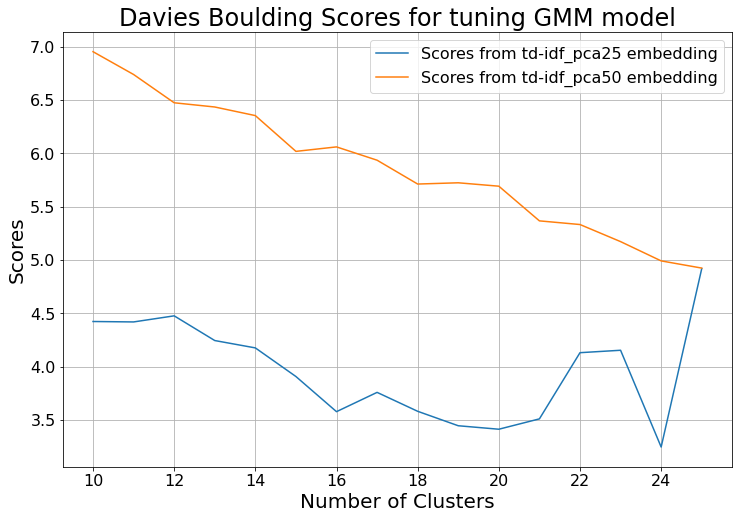

In [63]:
# Get a nice visualisation for the tuning the GMM model for the final report

ks = np.arange(10, 26)

f = plt.figure(figsize=(12, 8))

plt.plot(ks, gmm_scores, label='Scores from td-idf_pca25 embedding')
plt.plot(ks, gmm_scores_50, label='Scores from td-idf_pca50 embedding')

plt.title('Davies Boulding Scores for tuning GMM model', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Number of Clusters', fontsize=20)
plt.ylabel('Scores', fontsize=20)

plt.legend(fontsize=16)
plt.grid()

plt.show()

In [64]:
f.savefig('../figures/tune_gmm.pdf', bbox_inches='tight')